## FH Hagenberg: Automotive Computation
# Project 2: Pedestrian Detection

Welcome to the <b>second Automotive Computing project</b>!<br>
In this project you will implement a solution for detecting pedestrians in a single image!<br>Again the first part of your work is to compute the gradients in the images (you can copy the code of the first project). The next tast is to divide the image into non overlapping cells. For all these cells you have to calculate the orientation histogram. These cells are then parts of overlapping blocks in which all cell histograms are concatinated and normalized (to be robust against illumination).<br>
Finally (which is not the part of your work) you train a linear Support Vector machine and evaluate its performance (you have to write the metric functions).<br>
After you are able to observe the first results, implement the two alternative filters (3x1 and 1x3) for gradient computation which were presented in the lectures.<br>
Which parameters (normalization, block size, cell size) lead to the best results on the test set?

### Where does the images come from:
http://www.lookingatpeople.com/download-daimler-ped-class-benchmark/index.html

### Which restrictions do you have:
Do not use library functions which are able to calculate gradients, magnitutes, hough transformation etc. (in other words, the functions should be implemented on your own)

### Where can I get more information:
The interested reader can read the work of Dalal and Triggs:
https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf<br>
They developed the Histogram of Oriented Gradients descriptor for pedestrian detection. In the work you could find some parameters which could be of interest for you.

In [287]:
# First check the Python version
# If you have installed a different version, you should install the correct version to avoid conflicts
import sys
if sys.version_info.major != 2 or sys.version_info.minor != 7:
    print('You are running a different version of Python!\n\n' \
          'You should consider using Python 2.7.x.\n')
    print('Try installing the Python 2.7 version of anaconda.\n')

In [288]:
# Now get necessary libraries
try:
    import os # for file management
    import numpy as np # for numeric computations
    import math
    from scipy import ndimage
    
    from scipy.misc import imread, imsave, imresize
    from sklearn import svm
    from skimage import feature # for canny edge computation
    
    from PIL import Image
        
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    # this comment ensures that all images are plotted in this environment and not in a seperate window
    %matplotlib inline
    
except ImportError:
    print('You are missing some packages! ' \
          'Please check your Anaconda installation!')

All the steps before are not relevant for solving the pedestrian detection task. The first step here is to load a single image containing a pedestrian.<br>

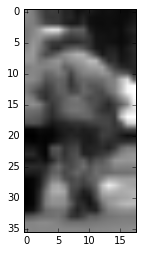

In [289]:
# load a single image
img = Image.open('../dataset/train/1/pos/img_00000.pgm')

numpyImage = None
if img is not None:
    numpyImage = np.array(img)
    plt.imshow(numpyImage, cmap='gray')

Now that we have plotted a single pedestrian we will implement all required steps which are necessary for a HOG descriptor:
1. Compute the gradient images
2. Subdivide the image into non overlapping cells
3. Compute the gradient orientation histogram for each cell
4. Put together a few cells to a block<br>
    a. Compute the normalized histogram for each block
5. Concatenate the block histograms to a large vector (Hog descriptor)

As in the last project, the functions are implemented and tested incremenally. The last step is to use this vector for classification.

# 1. Compute the gradient images.
Please refer to the gradient computation section of project 1.

In [290]:
def correlate3x3(kernel, image):
    """
    This function correlates a filter kernel (3x3) with an image
    
    Parameters
    ----------
    kernel : 2d numpy array
        This is the filter kernel used for the correlation
        
    image : 2d numpy array
        Image which should be correlated with a given kernel
        
    Returns
    -------
    filteredImage : 2d numpy array
        Image after the kernel was applied
    """
    pass

In [291]:
def gradientX(image):
    """
    Function computing the edges in X in an given image.
    The parameter image is a 2d numpy array.
    The function returns the edge-x image.
    
    Parameters
    ----------
    image : 2d numpy array
        Input image
        
    Returns
    -------
    gx : 2d numpy array
        Extracted horizontal edges
    """
    
    pass

In [292]:
def gradientY(image):
    """
    Function computing the edges in Y in an given image.
    The parameter image is a 2d numpy array.
    The function returns the edge-y image.
    Parameters
    ----------
    image : 2d numpy array
        Input image
        
    Returns
    -------
    gy : 2d numpy array
        Extracted vertical edges
    """
    
    pass

In [293]:
def getMagnitude(gx, gy):
    """
    Function computes the magnitude of the gradient
    
    Parameters
    ----------
    gx : 2d numpy array
        Extracted horizontal edges
        
    gx : 2d numpy array
        Extracted vertical edges
        
    Returns
    -------
    magnitudeImage : 2d numpy array
        Computed magnitudes
    """
    
    pass

In [294]:
def getGradientOrientations(gx,gy):
    """
    This function computes the gradient orientation "image".
    The values are either in radians or in degrees - you have to be aware of it
    
    Parameters
    ----------
    gx : 2d numpy array
        "Image" containing the horizontal edges
    
    gy : 2d numpy array
        "Image" containing the vertical edges

    Returns
    -------
    orientations : 2d numpy array
        The gradient orientations for each pixel stored in an "image".
        Angles in radians, in the range [-pi, pi].
    """
    pass 

In [295]:
gx = gradientX(numpyImage)
gy = gradientY(numpyImage)
magnitudes = getMagnitude(gx,gy)
directions = getGradientOrientations(gx,gy)

# 2. Subdivide the image into non overlapping cells

Your task is now to subdivide the given image into non overlapping cells. Lets define the size of each cell to be 6x6 pixels

In [296]:
# this function converts a list of lists into a single list
flatten = lambda l: [item for sublist in l for item in sublist]

In [297]:
def plotCells(cells, image):
    """
    This function plots the transformed parameters in the image
    
    Parameters
    ----------
    parameters : list of tuples
        The parameters computed by the function houghTransform(...)
        
    image : 2d numpy array
        Image which is populated with lines    
    """
    plt.imshow(image, cmap='gray')
    rows, cols = image.shape
    
    for cell in cells:
        [startColumn, startRow, endColumn, endRow] = cell.getCoordinates()
        endRow += 1
        endColumn += 1
        
        #left top -> right top
        plt.plot([startColumn, endColumn], [startRow, startRow], color='r', linestyle='-', linewidth=1)
        #left top -> left bottom
        plt.plot([startColumn, startColumn], [startRow, endRow], color='r', linestyle='-', linewidth=1)        
        # right bottom -> left bottom
        plt.plot([endColumn, startColumn], [endRow, endRow], color='r', linestyle='-', linewidth=1)
        # right bottom -> right top
        plt.plot([endColumn, endColumn], [endRow, startRow], color='r', linestyle='-', linewidth=1)
        
    plt.axis((0, cols, rows, 0))

In [298]:
class Cell:
    """
    A class containing all relevant functions for computing the orientation histogram
    """
    def __init__(self, numberOfBins, useSigned):
        """
        Constructor of the Cell class.
        
        Parameters
        ----------
        numberOfBins : int
            Number of bins for the orientation histogram

        useSigned : boolean
            Use signed (180°) or unsigned (360°) orientations
        """
        #self._gradientOrientationHistogram = np.zeros(numberOfBins)       
        self._gradientOrientationHistogram = [0] * numberOfBins
        
        self._angleImage = None
        self._magnitudeImage = None
        self._numberOfBins = numberOfBins
        
        # if signed: 0 ... 180
        # if unsigned: 0 ... 360
        self._signedGradient = useSigned
        
        self._startColumn = 0
        self._startRow = 0
        self._endColumn = 0
        self._endRow = 0
        
    def setCoordinates(self, startColumn, startRow, endColumn, endRow):
        """
        This function sets the coordinates of the cell relative to the image
        
        Parameters
        ----------
        startColumn : int
            The left most coordinate of the cell

        startRow : int
            The top most coordinate of the cell
            
        endColumn : int
            The right most coordinate of the cell

        endRow : int
            The bottom most coordinate of the cell
        """
        
        pass
        
    def getCoordinates(self):
        """
        This function return the coordinates of the cell relative to the image
        
        Return
        ----------
        List containing the left top corner and the right bottom border
        """
        
        pass

    def setDataRestrictedByInternalCoordinates(self, angles, magnitudes):
        """
        This function sets the internal data (angles and magnitudes).
        Since the variables angles and magnitudes have the size of the full patch (not the size of the cell)
        you have to extract the corresponding submatrix (defined by startColumn, startRow, endColumn, endRow)
        
        Parameters
        ----------
        angles : 2d numpy array
            Orientation of gradients

        magnitudes : 2d numpy array
            Gradient magnitudes
        """
        
        pass
                
    def createHistogram(self):
        """
        This function populates the gradient histogram of this cell.
        """
        
        pass
    
    def getHistogram(self):
        """
        This function returns the cell histogram
        
        Return
        ----------
        numpy array containing the cell's gradient orientation histogram.
        """
        
        pass
    
    def plotHistogram(self):
        """
        This function plots the cell's gradient orientation histogram.
        """
        bins = range(self._numberOfBins)
        plt.bar(bins,self._gradientOrientationHistogram)
        plt.title("Gradient Orientation Histogram of a cell")
        plt.ylabel("Magnitude vote")
        plt.xlabel("Bin")
        plt.show()

In [299]:
cellWidth = 6
cellHeight = 6

# we define 9 bins for the gradient orientation histogram
numberOfBins = 9 # <- EXPERIMENT
useSigned = False # <- EXPERIMENT

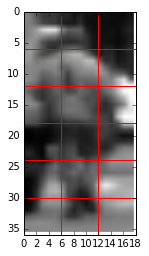

In [300]:
def subdivideIntoCells(image, cellHeight, cellWidth, numberOfBins, useSigned):
    """
    This function divides the image into tiles.

    Parameters
    ----------
    image : 2d numpy array
        The pedestrian or background imge

    cellHeight : int
        The height of a cell
        
    cellWidth : int
        The width of a cell
    
    numberOfBins : int
        The number of bins used for the gradient orientation histogram
        
    useSigned : boolean
        If true we use 180 degrees else 360 degrees
        
    Return
    ---------
    cellGrid - 2d grid of cells
    """

    
    # determine the number of cells used for the image        
    assert( (0 == (numRows % cellHeight)) and (0 == (numColumns % cellWidth)))
    

    # create a 2d grid of cells
    cellGrid = [[Cell(numberOfBins, useSigned) for j in range(numCellsHorizontal)] for i in range(numCellsVertical)]
    pass

In [ ]:
cellGrid = subdivideIntoCells(numpyImage, cellHeight, cellWidth, numberOfBins, useSigned)
plotCells(flatten(cellGrid), numpyImage)

## Question
What do you think is the purpose of the subdivision into cells?

## Test the histogram generation

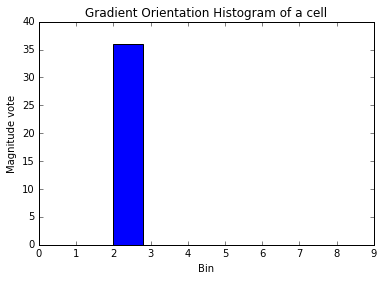

In [302]:
test_magnitudes = np.ones((6,6))
test_orientations = np.ones((6,6)) * 90.0 # only 90 degree angles
test_orientations = test_orientations * math.pi / 180.0
test_useSigned = True
test_numberOfBins = 9

test_cell = Cell(test_numberOfBins, test_useSigned)
test_cell.setCoordinates(0,0,5,5)
test_cell.setDataRestrictedByInternalCoordinates( test_orientations, test_magnitudes )
test_cell.createHistogram()
test_cell.plotHistogram()

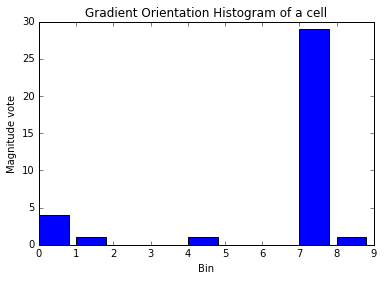

In [303]:
test_magnitudes = np.ones((6,6))
test_orientations = np.ones((6,6)) * 300
test_orientations[0,0] = 180
test_orientations[0,1] = 19
test_orientations[0,2] = 20
test_orientations[0,3] = 39
test_orientations[0,4] = 40
test_orientations[0,5] = 359
test_orientations[1,0] = 360
test_orientations = test_orientations * math.pi / 180.0
test_useSigned = True
test_numberOfBins = 9

test_cell = Cell(test_numberOfBins, test_useSigned)
test_cell.setCoordinates(0,0,5,5)
test_cell.setDataRestrictedByInternalCoordinates( test_orientations, test_magnitudes )
test_cell.createHistogram()
test_histogram = test_cell.plotHistogram()

## Question
What is described by the histograms?

# 3. Compute the gradient orientation histogram for each cell

After the cell grid is generated, we have to compute the gradient orientation histogram for each cell in the grid. Note that you also have to implement the funtion createHistogram in the class Cell.

In [304]:
def computeHistograms(cellGrid, magnitudes, gradientOrientations):
    """
    This function generates the cell grid and computes the histogram
    for each cell.

    Parameters
    ----------
    cellGrid : 2d list
        cell grid
    magnitudes : 2d numpy array
        of gradient magnitudes (same dimension as original image)
    gradientOrientations : 2d numpy array 
        of gradient angles (same dimension as original image)
      
    """
    pass

In [305]:
computeHistograms(cellGrid, magnitudes, directions)

# 4. Put together a few cells to a block

In [306]:
def plotBlocks(blocks, image):
    """
    This function plots all blocks in the image
    
    Parameters
    ----------
    blocks : list of tuples
        The parameters computed by the function houghTransform(...)
        
    image : 2d numpy array
        Image which is populated with lines    
    """
    plt.imshow(image, cmap='gray')
    rows, cols = image.shape
    
    for block in blocks:
        [startColumn, startRow, endColumn, endRow] = block.getBoundingBox()
        endRow += 1
        endColumn += 1
        
        #left top -> right top
        plt.plot([startColumn, endColumn], [startRow, startRow], color='b', linestyle='-', linewidth=1)
        #left top -> left bottom
        plt.plot([startColumn, startColumn], [startRow, endRow], color='b', linestyle='-', linewidth=1)        
        # right bottom -> left bottom
        plt.plot([endColumn, startColumn], [endRow, endRow], color='b', linestyle='-', linewidth=1)
        # right bottom -> right top
        plt.plot([endColumn, endColumn], [endRow, startRow], color='b', linestyle='-', linewidth=1)
    plt.axis((0, cols, rows, 0))

In [307]:
class Block:
    def __init__(self, blockNormalization=1):
        self._listOfComprisingCells = []
        
        # 0 ... l1 - norm
        # 1 ... l2 - norm
        # 2 ... l1 - sqrt norm
        self._blockNormlizationType = blockNormalization
        
        self._startColumn = 0
        self._startRow = 0
        self._endColumn = 0
        self._endRow = 0
    
    def addCellToBlock(self, cell):
        """
        This function adds a cell to this block

        Parameters
        ----------
        cell : Cell object
            A cell which is part of this block
        """
        pass
        
    def setBoundingBox(self, startColumn, startRow, endColumn, endRow):
        """
        This function sets the coordinates of the block

        Parameters
        ----------
        startColumn : int
            Starting column of the block
        
        startRow : int
            Starting row of the block
            
        endColumn : int
            End column of the block
        
        endRow : int
            End row of the block
        """
        pass
        
    def getBoundingBox(self):
        """
        Returns the coordinates of the block

        Return
        ----------
        list of startColumn, startRow, endColumn, endRow
        """
        
        pass        
        
    def getNormalizedBlockHistogram(self):
        """
        This function concatinates all histograms of all cells to the block histgram and normalizes it.

        Return
        ----------
        Normalized block histogram
        """
        
        pass

In [308]:
def mergeCellsIntoBlocks(cellGrid):
    """
    This function generates the block grid and attach all cells to blocks
    
    Parameters
    ----------
    cellGrid : 2d list of Cells
        All existing cells
        
    Return
    ----------
    blockGrid : 2d list of Blocks
        All blocks containing cells
    """        
    
    

    # create a 2d grid of blocks
    blockGrid = [[Block() for j in range(numBlocksHorizontal)] for i in range(numBlocksVertical)]

    pass

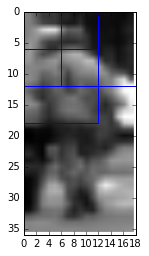

In [309]:
blockGrid = mergeCellsIntoBlocks(cellGrid)
# for the first test lets just display the first three blocks
plotBlocks(flatten(blockGrid)[0:3], numpyImage)

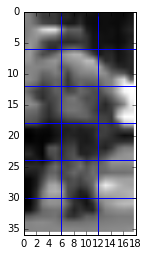

In [310]:
# for the first test lets display all blocks
plotBlocks(flatten(blockGrid), numpyImage)

# 4a. Compute the normalized histogram for each block
Implement the function <b>getNormalizedBlockHistogram(...)</b> in the Block class

## Question
Why do we use blocks and normalize the concatinated histograms?

# 5. Concatenate the block histograms to a large vector
This is now the last function which needs to be implemented. In this function you have to iterate over all blocks and concatenate all normalized block histograms

In [311]:
def getConcatinateBlockHistograms(blockGrid):
    """
    This function concatinates the histograms of each block
    
    Parameters
    ----------
    blockGrid : 2d list of Blocks
        All existing blocks
        
    Return
    ----------
    concatinated histograms (HOG descriptor)
    """
    pass

# Write a function which computes the hog descriptor
You have now implemented the full functionality to compute the HOG descriptor. Your final task is to write a function which takes as parameter an image and returns its HOG descriptor.<br>
This function will be used in the code below for each positive and negative image. The resulting descriptors are used for the training of a linear SVM. You will see how good the learned model can distinct between pedestrians and something else. Of course, there will be some false positives (background which is classified as a pedestrian) - there are much more powerful methods these days.

In [313]:
def getHogDescriptor(numpyImage):
    """
    This function should do all relevant steps to compute the HOG descriptor for a single image
    
    Parameters
    ----------
    numpyImage : 2d numpy array
        The image patch
        
    Return
    ----------
    HOG descriptor
    """
    
    pass

# Train a classifier with all positive and negative patches
We're going to be using the SVC (support vector classifier) SVM (support vector machine). Our kernel is going to be linear, and C is equal to 1.0. What is C you ask? Don't worry about it for now, but, if you must know, C is a valuation of "how badly" you want to properly classify, or fit, everything.<br>
Before you can train the classifier, you have to load the training and test data (we have provided the code for you - you just need to execute it)

In [314]:
def loadImagesFromFolder(folder):
    """
    This function loads all images in a given folder
    """
    images = []
    
    # iterate all files in the given folder
    for filename in os.listdir(folder):
        # load image
        img = Image.open(os.path.join(folder,filename))
        if img is not None:
            numpyArray = np.array(img)
            images.append(numpyArray)
        img.close()            
    return images

In [329]:
def loadTrainingData():
    """
    This function loads the relevant training data 
    (pedestrians and non-pedestrians) for you.
    """
    
    # build path to training images
    cwd = os.getcwd()
    workingDir = cwd.replace('\\','/')
    workingDir = workingDir.replace('code','dataset/train/')
    
    posTrainPart1 = loadImagesFromFolder(workingDir+'1/pos/')
    posTrainPart2 = loadImagesFromFolder(workingDir+'2/pos/')
    posTrainPart3 = loadImagesFromFolder(workingDir+'3/pos/')
    
    negTrainPart1 = loadImagesFromFolder(workingDir+'1/neg/')
    negTrainPart2 = loadImagesFromFolder(workingDir+'2/neg/')
    negTrainPart3 = loadImagesFromFolder(workingDir+'3/neg/')
    
    posTrainingPatches = posTrainPart1 + posTrainPart2 + posTrainPart3
    negTrainingPatches = negTrainPart1 + negTrainPart2 + negTrainPart3

    print 'Training data: #%d positive patches and #%d negative patches loaded.' % (len(posTrainingPatches), len(negTrainingPatches))
    return posTrainingPatches, negTrainingPatches

In [330]:
def loadTestData():
    """
    This function loads the relevant test data 
    (pedestrians and non-pedestrians) for you.
    """
    
    # build path to training images
    cwd = os.getcwd()
    workingDir = cwd.replace('\\','/')
    workingDir = workingDir.replace('code','dataset/test/')
    
    posTestPart1 = loadImagesFromFolder(workingDir+'T1/pos/')
    posTestPart2 = loadImagesFromFolder(workingDir+'T2/pos/')
    
    negTestPart1 = loadImagesFromFolder(workingDir+'T1/neg/')
    negTestPart2 = loadImagesFromFolder(workingDir+'T2/neg/')
    
    posTestPatches = posTestPart1 + posTestPart2
    negTestPatches = negTestPart1 + negTestPart2

    print 'Test data: #%d positive patches and #%d negative patches loaded.' % (len(posTestPatches), len(negTestPatches))
    return posTestPatches, negTestPatches

In [331]:
# choose a linear Support Vector Machine as classifier
clf = svm.SVC(kernel='linear', C = 1.0)

After we have loaded the data and selected the learning method, we have to attach the labels for the training data and start the training.

In [332]:
# load an prepare the training data
pos, neg = loadTrainingData()
training_labels = [1] * len(pos) + [0] * len(neg)
training_patches = pos + neg
training_descriptors = []

for training_patch in training_patches:
    training_descriptors.append(getHogDescriptor(training_patch))

Training data: #14400 positive patches and #15000 negative patches loaded.


In [333]:
# learn the model
clf.fit(training_descriptors,training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [334]:
# load an prepare the training data
pos, neg = loadTestData()
test_labels = [1] * len(pos) + [0] * len(neg)
test_patches = pos + neg
test_descriptors = []

for test_patch in test_patches:
    test_descriptors.append(getHogDescriptor(test_patch))

Test data: #9600 positive patches and #10000 negative patches loaded.


In [335]:
# predict test patches
test_predictions = clf.predict(test_descriptors)

In [336]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Taken from: http://scikit-learn.org
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [337]:
from sklearn.metrics import confusion_matrix
import itertools

Confusion matrix, without normalization
[[7814 2186]
 [1967 7633]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.2   0.8 ]]


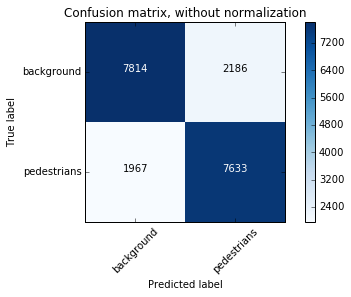

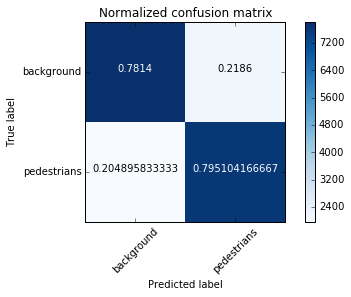

In [338]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, test_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names=['background', 'pedestrians']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [339]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In a binary classification task, the terms "positive" and "negative" refer to the classifier's prediction, and the terms "true" and "false" refer to whether that prediction corresponds to the external judgment (sometimes known as the "observation"). Given these definitions, we can formulate the following table:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-3oug{background-color:#fd6864;text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-l5iw{background-color:#32cb00;text-align:center;vertical-align:top}
.tg .tg-t8yp{background-color:#fd6864;text-align:right;vertical-align:top}
.tg .tg-bv1d{background-color:#32cb00;text-align:right;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"><br></th>
    <th class="tg-amwm" colspan="2">Actual class (observation)</th>
  </tr>
  <tr>
    <td class="tg-amwm" rowspan="2">Predicted class<br>(expectation)</td>
    <td class="tg-l5iw">tp (true positive)<br>Correct result</td>
    <td class="tg-t8yp">fp (false positive)<br>Unexpected result</td>
  </tr>
  <tr>
    <td class="tg-3oug">fn (false negative)<br>Missing result</td>
    <td class="tg-bv1d">tn (true negative)<br>Correct absence of result</td>
  </tr>
</table>

In this context, we can define the notions of precision and recall
$$\text{precision} = \frac{\text{tp}}{\text{tp + fp}}$$
$$\text{recall} = \frac{\text{tp}}{\text{tp + fn}}$$

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [340]:
def getPrecision(test_labels, test_predictions):
    pass

In [341]:
def getRecall(test_labels, test_predictions):
    pass

In [342]:
print 'Precision ', getPrecision(test_labels, test_predictions), ' ', 'Recall: ', getRecall(test_labels, test_predictions)

Precision  0.777370404318   Recall:  0.795104166667


## Question:
Try fo beat a precision of 0.83 and a recall of 0.77! If you are wondering, yes there is potential for improvement!
What are your numbers? How did you achieve this?

##  Implement alternative filters (optional) and experiment with parameters
Implement additional functions (e.g. gradientX2, gradientY2, correlation3x1, correlation1x3) for computing the gradient in x and y direction (take a look in the lectures) with the 3x1 and 1x3 filter mask.<br>
Experiment with the kind of histogram normalization, block size, cell size. If you want, you can also experiment with the parameters of the SVM.

In [ ]:
def correlate3x1(kernel, image):
    """
    This function correlates a filter kernel (3x1) with an image
    
    Parameters
    ----------
    kernel : 2d numpy array
        This is the filter kernel used for the correlation
        
    image : 2d numpy array
        Image which should be correlated with a given kernel
        
    Returns
    -------
    filteredImage : 2d numpy array
        Image after the kernel was applied
    """

In [ ]:
def correlate1x3(kernel, image):
    """
    This function correlates a filter kernel (1x3) with an image
    
    Parameters
    ----------
    kernel : 2d numpy array
        This is the filter kernel used for the correlation
        
    image : 2d numpy array
        Image which should be correlated with a given kernel
        
    Returns
    -------
    filteredImage : 2d numpy array
        Image after the kernel was applied
    """

In [ ]:
def gradientX2(image):
    """
    Function computing the edges in X in an given image.
    The parameter image is a 2d numpy array.
    The function returns the edge-x image.
    
    Parameters
    ----------
    image : 2d numpy array
        Input image
        
    Returns
    -------
    gx : 2d numpy array
        Extracted horizontal edges
    """

In [ ]:
def gradientY2(image):
    """
    Function computing the edges in Y in an given image.
    The parameter image is a 2d numpy array.
    The function returns the edge-y image.
    
    Parameters
    ----------
    image : 2d numpy array
        Input image
        
    Returns
    -------
    gy : 2d numpy array
        Extracted horizontal edges
    """

In [ ]:
def getHogDescriptorV2(numpyImage):
    """
    This function should do all relevant steps to compute the HOG descriptor for a single image
    
    Parameters
    ----------
    numpyImage : 2d numpy array
        The image patch
        
    Return
    ----------
    HOG descriptor
    """
    
    pass